# Data Visualisation

## Objectives

1. Create figures to show average infected and healthy leaves
2. Create figures to show variability of infected and healthy leaf images
3. Create figures to show difference between average healthy and infected leaves
4. Create image montage function for healthy and infected leaves
5. Analyse and determine differences in number/amount of green pixels in healthy and infected leaves.

## Inputs

- inputs/mildew_dataset/cherry-leaves/test
- inputs/mildew_dataset/cherry-leaves/train
- inputs/mildew_dataset/cherry-leaves/validation

## Outputs

- Image shape embeddings pickle file
- Figures to show average and variability of infected and healthy leaves
- Figures to show difference between average healthy and infected leaves
- Create image montage function
- Create figures to show green pixel analysis


## Set Directory

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detector/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print(current_dir)

/workspaces/mildew-detector/jupyter_notebooks


In [10]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detector'

In [ ]:
%pip install -r /workspaces/mildew-detector/requirements.txt

## Import Libraries

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread
from PIL import Image

## Set Input Directories

Note - Check my_data_dir points to correct folder, change for resized images

In [6]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves/resized'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

print('train path', train_path)
print('validation path', val_path)
print('test path', test_path)
current_dir

train path inputs/mildew_dataset/cherry-leaves/resized/train
validation path inputs/mildew_dataset/cherry-leaves/resized/validation
test path inputs/mildew_dataset/cherry-leaves/resized/test


'/workspaces/mildew-detector'

## Set Output Directories

In [7]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set Labels Names

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


## Visualisation of Image Data

#### Image Shape

In [ ]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
dim1_max = int(np.array(dim1).max())
dim2_max = int(np.array(dim2).max())
dim1_min = int(np.array(dim1).min())
dim2_min = int(np.array(dim2).min())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")
print(f"Maximums: {dim1_max} {dim2_max}")
print(f"Minimums: {dim1_min} {dim2_min}")


#### No Variability in Train Image File Dimensions

The above analysis shows all images are of the same size and shape.

NOTE - The below function acts as a confirmation to check and return the number of images that are of different sizes, this is tweaked for use with 100 pixel images.

In [ ]:
different_images = []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        if d1 != 100:
            different_images.append(d1)
        length = len(different_images)
print(f" Number of images that are not 100x100 pixels {different_images}  {length}")
        


In [ ]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

In [ ]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

## Average and Variability of Images per Label - Used to load images to array

#### Function to load images to an array

Note - Resizing part of this function won't have any effect as all images are same size. Look at how the function is called in next cell.

In [ ]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: a limit is set otherwise it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


#### Load image shapes

In below, as the function is being called with new_size=image shape, and image_shape is the calculated mean across the training images (which is either 256 exactly or 100 exactly for the resized images), no actual change will occur on image sizes. Keeping in for simplicity for now. 

In [ ]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

#### Plot and Save Mean Variability of images per label


In [ ]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")


In [ ]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

## Difference between average infected and uninfected cherry leaf images

In [ ]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()


In [ ]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )


### Pixel Colour Counter

The function below loops through a selection of images and counts the number of green pixels, plotting the differences on a line graph and communicating the average number of green pixels across all images in the title. 
Note - Change path and plot title for healthy and powdery mildew images.

125.87 green test 51


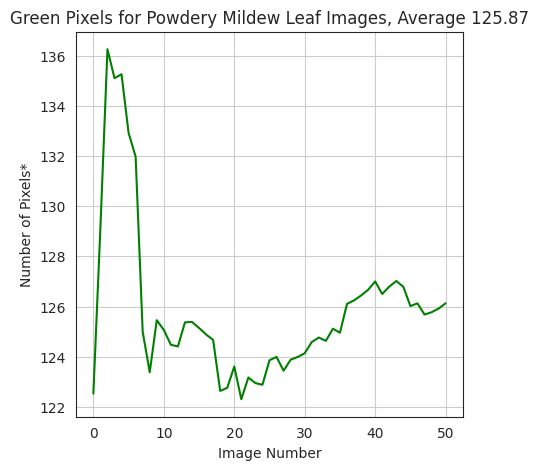

In [20]:
def colour_checker(path):
    """
    This function counts the number of green pixels in a given number of leaf
    images. This value is divided by the number of images to keep the value
    representative. An average of green pixels across all images is also 
    captured and used in the figure title.
    """
    count = 0
    run_count = 0
    green_pixels = 0
    list_for_images = []
    
    for item in os.listdir(path):
        if count < 51:
            pathway = path + item
            count += 1
            if os.path.isfile(pathway):
                img = Image.open(pathway)
                img.convert('RGB')
                for x in range(0, 100):
                    for y in range(0, 100):
                        r, g, b = img.getpixel((x,y))
                        green_pixels += g
                        run_count += 1
            thisdict = dict(green = green_pixels/run_count)
            list_for_images.append(thisdict)
    df= pd.DataFrame.from_dict(list_for_images)
    green_average = round(np.average(df['green']), 2)
    print(green_average, "green test", len(df['green']))

    #This code takes the dataframe which contains the details of the green
    #pixel count and plots them in a line graph, saves plot also.
    figure_size = (5, 5)
    plt.figure(figsize=figure_size)
    plt.plot(df['green'], color='green')
    plt.xlabel("Image Number")
    plt.ylabel("Number of Pixels*")
    plt.title(f"Green Pixels for Powdery Mildew Leaf Images, Average {green_average}")
    plt.grid(True)
    plt.savefig(f'{file_path}/powdery_mildew_pixels.png',
            bbox_inches='tight')
    plt.show()
    
colour_checker(my_data_dir + '/train/powdery_mildew/')


## Image Montage

In [ ]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class to display
    if label_to_display in labels:

        # checks if the montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")


In [ ]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")
